# Tweet Sentiment Extraction

## 0. Setup

In [1]:
#@title ## Install Dependencies
#@markdown - kaggle client: downloads dataset

%%capture --no-stdout --no-stderr
!pip install -U kaggle

# %%python
print("Dependencies successfully installed.")

Requirement already up-to-date: kaggle in /usr/local/lib/python3.7/dist-packages (1.5.10)
Dependencies successfully installed.


In [2]:
#@title ## Download Kaggle Dataset
#@markdown Dataset: Annotated Corpus for Named Entity Recognition <br>
#@markdown [Tweet Sentiment Extraction](https://www.kaggle.com/c/tweet-sentiment-extraction/leaderboard)
#@markdown <br><br>
#@markdown "My ridiculous dog is amazing." [sentiment: positive]
#@markdown With all of the tweets circulating every second it is hard to tell whether the sentiment behind a specific tweet will impact a company, or a person's, brand for being viral (positive), or devastate profit because it strikes a negative tone.
!pip list | grep kaggle
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c tweet-sentiment-extraction
!unzip -o /content/train.csv.zip

kaggle                        1.5.10        
  0% 0.00/41.4k [00:00<?, ?B/s]
100% 41.4k/41.4k [00:00<00:00, 14.8MB/s]
  0% 0.00/307k [00:00<?, ?B/s]
100% 307k/307k [00:00<00:00, 41.8MB/s]
  0% 0.00/1.23M [00:00<?, ?B/s]
100% 1.23M/1.23M [00:00<00:00, 82.9MB/s]
Archive:  /content/train.csv.zip
  inflating: train.csv               


In [3]:
import collections
import os
import random
import re
import string
import warnings
warnings.filterwarnings("ignore")

import nltk.corpus
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objs, express, figure_factory
from google.colab import data_table

In [4]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

In [5]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [7]:
train.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,365711c26e,I can`t upload a picture. Everything`s too big,good,neutral
freq,1,1,199,11118


In [8]:
train.dropna(inplace=True)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [11]:
sent_groups = train.groupby("sentiment").count()["text"].reset_index().sort_values(by="text", ascending=False)
sent_groups.style.background_gradient(cmap="Oranges")

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


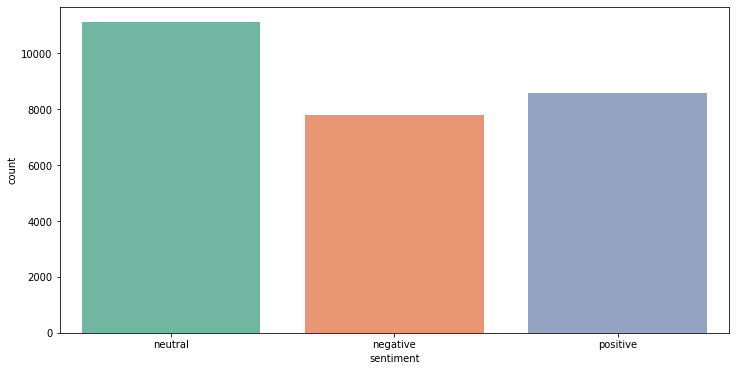

In [12]:
plt.figure(figsize=(12, 6))
palette = sns.color_palette("Set2")
sns.countplot(x="sentiment", data=train, palette=palette);

In [13]:
fig = graph_objs.Figure(graph_objs.Funnelarea(
                    text = sent_groups.sentiment,
                    values = sent_groups.text,
                    title = {
                        "position": "top center",
                        "text": "Funnel-Chart of Sentiment Distribution"
                    }
                ))
fig.show()

In [14]:
data_table.DataTable(train.sample(1000), include_index=False, num_rows_per_page=10)

,textID,text,selected_text,sentiment
14818,01e21d2e1d,"Morning, up early to travel to today`s game bu...",happy,positive
21502,2c8306a852,#mikeywayday? Count me IN,Count me IN,neutral
16015,13a9be1098,Haha same!!! But its gonna be awhile til it c...,Haha same!!! But its gonna be awhile til it co...,neutral
23883,1672ec347b,sourish limbs is preventing me from gg out on ...,not happy.,negative
19348,0321cdf978,: Sad But True :: I SHouldnt Right?,Sad But True,negative
...,...,...,...,...
5885,51ca53147d,hungraaaaaaaaay. i`ll just eat. don`t go away ...,hungraaaaaaaaay. i`ll just eat. don`t go away ...,neutral
1299,f854b71b06,hell yeah! Belgian beer is the bomb!! :p,hell yeah!,positive
26304,f49a440403,i`m totally gonna have money to actually buy ...,i`m totally gonna have money to actually buy a...,neutral
2192,6a7d4dbb87,Toast in the morning,Toast in the morning,neutral


In [15]:
def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [16]:
result_jaccard = []

for idx, row in train.iterrows():
    sent1 = row.text
    sent2 = row.selected_text
    
    jaccard_score = jaccard(sent1, sent2)
    result_jaccard.append([sent1, sent2, jaccard_score])
    
jaccard = pd.DataFrame(result_jaccard, columns=["text", "selected_text", "jaccard_score"])
train = train.merge(jaccard, how='outer')

In [17]:
train['num_word_selected'] = train['selected_text'].apply(lambda x: len(str(x).split()))
train['num_word_text'] = train['text'].apply(lambda x: len(str(x).split()))
train['difference_in_words'] = train['num_word_text'] - train['num_word_selected']

In [18]:
data_table.DataTable(train.sample(1000), include_index=False, num_rows_per_page=10)

,textID,text,selected_text,sentiment,jaccard_score,num_word_selected,num_word_text,difference_in_words
4587,a4439217cb,I`m making a logo on photoshop & it didn`t wor...,I`m making a logo on photoshop & it didn`t wor...,neutral,1.000000,15,15,0
7949,1bfc47cb11,"lol, I haven`t made anything yet, I`ve just s...","lol, I haven`t made anything yet, I`ve just sp...",neutral,1.000000,18,18,0
140,3e67a75303,Today is going to be a normal day for I hope. ...,Today is going to be a normal day for I hope. ...,neutral,1.000000,31,31,0
19155,f092eb7907,Really disappointed I can`t make it to bloomin...,disappointed,negative,0.052632,1,20,19
8734,d49267d905,Can I bring yself to go for the 1000 Heroism b...,Can I bring yself to go for the 1000 Heroism b...,neutral,1.000000,12,12,0
...,...,...,...,...,...,...,...,...
13985,8e13f7c528,"I`d love to, but i`m all the way in India.",love,positive,0.100000,1,10,9
16342,fc8ed01f87,But I have to cause I missed a lot of classes,missed,negative,0.100000,1,11,10
23168,da73f54df2,"Back from hospital, now at work... later studi...","Back from hospital, now at work... later studi...",neutral,1.000000,9,9,0
12014,14909b38c3,My bet on Mumbai Indians today... Anyone to ta...,My bet on Mumbai Indians today... Anyone to ta...,neutral,1.000000,16,16,0


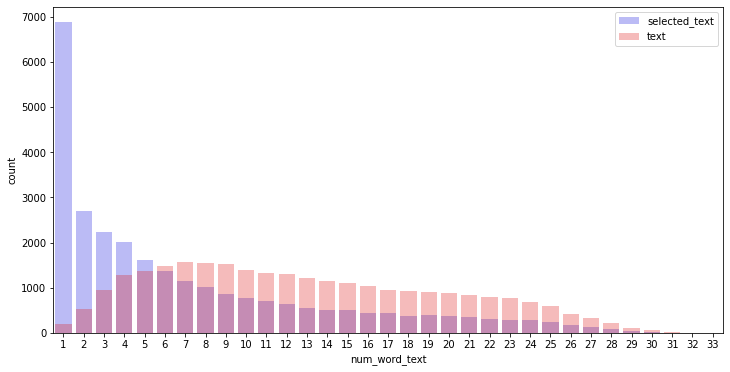

In [19]:
hist_data = [train['num_word_selected'], train['num_word_text']]

fig, axes = plt.subplots(figsize=(12, 6))
sns.countplot(train['num_word_selected'], ax=axes, color='blue', alpha=0.3, label='selected_text')
sns.countplot(train['num_word_text'], ax=axes, color='red', alpha=0.3, label='text')
axes.legend()
fig.show()

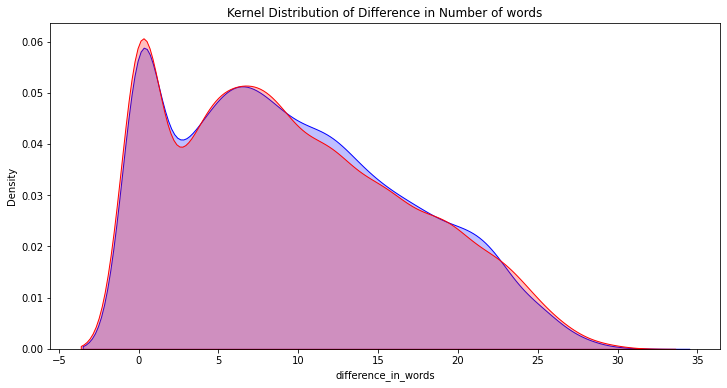

In [20]:
plt.figure(figsize=(12, 6))
p1 = sns.kdeplot(
        train[train['sentiment'] == 'positive']['difference_in_words'],
        shade=True,
        color='b',
        label='positive').set_title('Kernel Distribution of Difference in Number of words')
p2 = sns.kdeplot(
        train[train['sentiment'] == 'negative']['difference_in_words'],
        shade=True,
        color='r',
        label='positive')

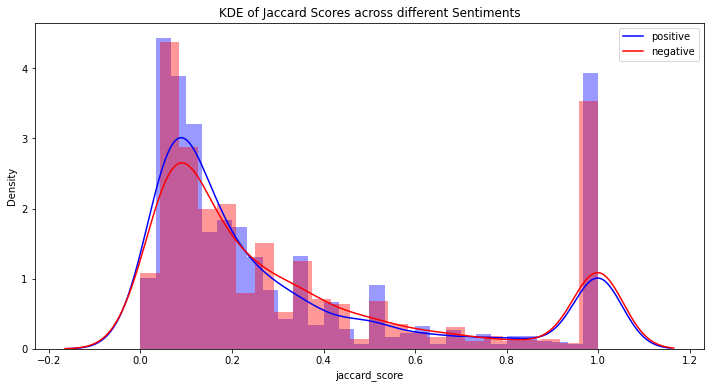

In [21]:
plt.figure(figsize=(12, 6))
p1 = sns.distplot(
        train[train['sentiment'] == 'positive']['jaccard_score'],
#         shade=True,
        color='b',
        label='positive'
        ).set_title('KDE of Jaccard Scores across different Sentiments')
p2 = sns.distplot(
        train[train['sentiment'] == 'negative']['jaccard_score'],
#         shade=True,
        color='r',
        label='negative')
plt.legend(labels=['positive', 'negative'])

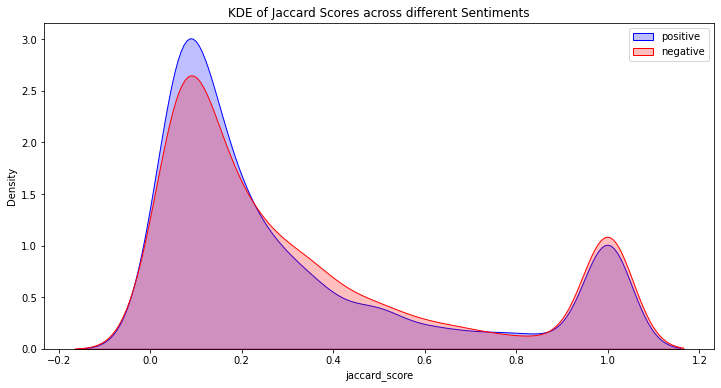

In [22]:
plt.figure(figsize=(12, 6))
p1 = sns.kdeplot(
        train[train['sentiment'] == 'positive']['jaccard_score'],
        shade=True,
        color='b',
        label='positive'
        ).set_title('KDE of Jaccard Scores across different Sentiments')
p2 = sns.kdeplot(
        train[train['sentiment'] == 'negative']['jaccard_score'],
        shade=True,
        color='r',
        label='negative')
plt.legend(labels=['positive', 'negative'])